In [ ]:
pip install loguru


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import nltk
from nltk.corpus import treebank
from collections import Counter
from nltk.tokenize import TreebankWordTokenizer
from loguru import logger
import time
import argparse
import matplotlib.pyplot as plt
import os
import pickle as pkl
from safetensors.torch import save_file, load_file
import json

In [ ]:
# Set NLTK data path to project's data directory
nltk_data_path = os.path.join(os.getcwd(), 'data', 'nltk_data')
nltk.data.path.append(nltk_data_path)

# Download required NLTK data
if not os.path.exists(nltk_data_path):
    print(f"Downloading NLTK data to: {nltk_data_path}")
    nltk.download('treebank', download_dir=nltk_data_path)
    nltk.download('punkt', download_dir=nltk_data_path)

[nltk_data] Downloading package treebank to /content/data/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package punkt to /content/data/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def load_and_preprocess_data():
    """
    Load and preprocess text data from Penn Treebank corpus.

    Returns:
        tuple: Contains three lists of tokenized sentences:
            - train_data: Training set (80% of data)
            - test_data: Test set (10% of data)
            - val_data: Validation set (10% of data)

    Each sentence is preprocessed by:
        1. Converting to lowercase
        2. Tokenizing using TreebankWordTokenizer
        3. Splitting into train/test/val sets
    """
    tokenizer = TreebankWordTokenizer()

    # Get sentences from Penn Treebank corpus
    sentences = treebank.sents()

    # Process each sentence
    processed = []
    for sent in sentences:
        # E sent is a list of words
        # Join the sentence into a single string and tokenize
        text = ' '.join(sent)
        tokens = tokenizer.tokenize(text.lower())
        processed.append(tokens)

    # Split into train, test, and validation sets
    train_data = processed[:int(len(processed) * 0.8)]
    test_data = processed[int(len(processed) * 0.8):int(len(processed) * 0.9)]
    val_data = processed[int(len(processed) * 0.9):]

    return train_data, test_data, val_data

In [ ]:
def build_voab(data, min_freq=2):
    """
    Build vocabulary from training data with minimum frequency threshold.

    Args:
        data (list): List of tokenized sentences where each sentence is a list of tokens
        min_freq (int, optional): Minimum frequency threshold for including words. Defaults to 2.

    Returns:
        tuple: Contains two dictionaries:
            - word_to_idx: Maps words to unique integer indices
            - idx_to_word: Maps indices back to words

    The vocabulary includes special tokens:
        - <unk>: Unknown words
        - <pad>: Padding token
        - <bos>: Beginning of sentence
        - <eos>: End of sentence
    """
    counter = Counter()
    for sent in data:
        counter.update(sent)

    # Create vocabulary with special tokens
    words = ['<unk>', '<pad>', '<bos>', '<eos>']
    words.extend([word for word, freq in counter.items() if freq >= min_freq])

    word_to_idx = {word: idx for idx, word in enumerate(words)}
    idx_to_word = {idx: word for idx, word in enumerate(words)}

    return word_to_idx, idx_to_word


In [ ]:
def process_data(data, word_to_idx):
    """
    Process raw text data into model-ready format by converting tokens to indices.

    Args:
        data (list): List of tokenized sentences where each sentence is a list of tokens
        word_to_idx (dict): Dictionary mapping words to unique integer indices

    Returns:
        list: List of torch tensors, where each tensor contains the indices for a sentence
            including <bos> and <eos> tokens

    Each sentence is processed by:
        1. Converting tokens to their vocabulary indices
        2. Adding beginning-of-sentence (<bos>) and end-of-sentence (<eos>) tokens
        3. Converting to a PyTorch tensor
    """
    processed = []
    for sent in data:
        # convert tokens to indices
        indices = [word_to_idx.get(token, word_to_idx['<unk>']) for token in sent]
        # Add <bos> and <eos> tokens
        indices = [word_to_idx['<bos>']] + indices + [word_to_idx['<eos>']]
        processed.append(torch.tensor(indices))

    return processed

In [ ]:
def create_batches(data, word_to_idx, batch_size=32):
    """
    Create batches from processed data for model training.

    Args:
        data (list): List of torch tensors containing processed sentences
        word_to_idx (dict): Dictionary mapping words to unique integer indices
        batch_size (int, optional): Size of each batch. Defaults to 32.

    Returns:
        list: List of torch tensors, where each tensor is a batch of padded sequences
            with shape (batch_size, max_sequence_length)

    The function:
        1. Sorts sequences by length in descending order for efficient padding
        2. Groups sequences into batches of specified size
        3. Pads shorter sequences in each batch to match the longest sequence
        4. Converts batches to torch tensors
    """
    data.sort(key=lambda x: len(x), reverse=True)
    total_len = len(data)
    num_batches = (total_len + batch_size - 1) // batch_size

    batches = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        max_len = len(batch[0])
        padded = [torch.cat([seq, torch.tensor([word_to_idx['<pad>']] * (max_len - len(seq)))]) if len(seq) < max_len else seq for seq in batch]
        batches.append(torch.stack(padded))
    return batches

In [ ]:
class Network(nn.Module):
    """
    Neural network model for language modeling using LSTM.

    Args:
        vocab_size (int): Size of the vocabulary
        embed_size (int): Dimension of word embeddings
        hidden_size (int): Number of features in the hidden state
        num_layers (int): Number of recurrent layers
        cell (str, optional): Type of RNN cell to use. Currently only supports 'lstm'. Defaults to 'lstm'
        dropout (float, optional): Dropout probability. Defaults to 0.5

    Attributes:
        layers (int): Number of recurrent layers
        hidden_size (int): Size of hidden state
        embed (nn.Embedding): Word embedding layer
        cell (nn.LSTM): LSTM layer
        dropout (nn.Dropout): Dropout layer
        fc (nn.Linear): Final linear layer that maps to vocabulary size
    """
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, cell='lstm', dropout=0.5):
        super(Network, self).__init__()
        self.layers = num_layers
        self.hidden_size = hidden_size

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.cell = None
        if cell == 'lstm':
            # Point: difference between nn.LSTM and nn.LSTMCell
            self.cell = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        elif cell == 'gru':
            self.cell = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length)
            hidden (tuple, optional): Initial hidden state. Defaults to None

        Returns:
            tuple:
                - logits (torch.Tensor): Output logits of shape (batch_size, sequence_length, vocab_size)
                - hidden (tuple): Final hidden state and cell state
        """
        batch_size = x.size(0)
        if hidden is None:
            h0 = torch.zeros(self.layers, batch_size, self.hidden_size).to(x.device)
            c0 = torch.zeros(self.layers, batch_size, self.hidden_size).to(x.device)
            hidden = (h0, c0)

        embeds = self.dropout(self.embed(x))    #point: why dropout here?
        output, hidden = self.cell(embeds, hidden)
        output = self.dropout(output)
        logits = self.fc(output)
        return logits, hidden

In [ ]:
def train(model, train_batches, criterion, optimizer, device):
    """
    Train the model for one epoch.

    Args:
        model (nn.Module): The neural network model
        train_batches (torch.Tensor): Training data batches
        criterion: Loss function
        optimizer: Optimizer for updating model parameters

    Returns:
        float: Average loss over all batches for this epoch
    """
    model.train()
    total_loss = 0.0

    for batch in train_batches:
        optimizer.zero_grad()
        inputs = batch[:, :-1].to(device)   # all tokens except last
        targets = batch[:, 1:].to(device)  # all tokens except first
        outputs, _ = model(inputs)
        loss = criterion(outputs.reshape(-1, outputs.size(-1)),
                         targets.reshape(-1))
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # gradient clipping
        optimizer.step()

    # compute loss
    total_loss += loss.item()
    total_loss = total_loss / len(train_batches)

    return total_loss


def evaluate(model, eval_batches, criterion, device):
    """
    Evaluate the model on validation/test data.

    Args:
        model (nn.Module): The neural network model
        eval_batches (torch.Tensor): Evaluation data batches
        criterion: Loss function

    Returns:
        float: Average loss over all batches in the evaluation set
    """
    model.eval()
    total_loss = 0.0

    # point: why no_grad() is needed when we have model.eval()
    with torch.no_grad():
        for batch in eval_batches:
            inputs = batch[:, :-1].to(device)
            targets = batch[:, 1:].to(device)

            outputs, _ = model(inputs)
            loss = criterion(outputs.reshape(-1, outputs.size(-1)),
                             targets.reshape(-1))
            total_loss += loss.item()


    return total_loss / len(eval_batches)

def calculate_perplexity(loss):
    return torch.exp(torch.tensor(loss))

In [ ]:
def visualize(train_metric, valid_metric, title, xlabel, ylabel, figname):
    """
    Visualize and save a metric plot.

    Args:
        metric (list): Values to plot
        title (str): Title of the plot
        xlabel (str): Label for x-axis
        ylabel (str): Label for y-axis
        figname (str): Filename to save the plot

    Returns:
        None
    """
    plt.plot(train_metric, label='train')
    plt.plot(valid_metric, label='valid')
    plt.legend(loc='upper right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(figname)
    plt.close()

In [ ]:
# function to load vocabulary mappings
def load_vocab(vocab_path):
    with open(vocab_path, 'r') as f:
        vocab_dict = json.load(f)
    return vocab_dict['word_to_idx'], vocab_dict['idx_to_word']

# function to load tensors from safetensors file
def load_tensors(file_path):
    loaded_tensors = load_file(file_path)
    return loaded_tensors['train'], loaded_tensors['valid'], loaded_tensors['test']


In [ ]:
def generate_text(model, word_to_idx, idx_to_word, device, seed_text='the', max_length=20):
    """Generate text using the trained language model.

    Args:
        model: The trained language model
        word_to_idx (dict): Dictionary mapping words to indices
        idx_to_word (dict): Dictionary mapping indices to words
        seed_text (str, optional): Initial text to condition generation on. Defaults to 'the'.
        max_length (int, optional): Maximum number of words to generate. Defaults to 20.

    Returns:
        str: Generated text as a space-separated string of words
    """
    model.eval()
    words = seed_text.lower().split()
    indices = [word_to_idx.get(word, word_to_idx['<unk>']) for word in words]
    indices = [word_to_idx['<bos>']] + indices

    with torch.no_grad():
        for _ in range(max_length):
            input_tensor = torch.tensor(indices).unsqueeze(0).to(device)
            output, _ = model(input_tensor)
            next_token_idx = output[0, -1].argmax().item()

            if next_token_idx == word_to_idx['<eos>']:
                break

            indices.append(next_token_idx)

    generated_words = [idx_to_word[idx] for idx in indices[1:]] # skip <bos>

    return ' '.join(generated_words)

In [ ]:
trial_name = 'lstm-1'

if not os.path.exists('logs'): os.makedirs('logs')
log_dir = os.path.join('logs', trial_name)
if not os.path.exists(log_dir): os.makedirs(log_dir)

# configure the logger
logger.add(os.path.join(log_dir, 'logs.log'), format="{time:YYYY-MM-DD HH:mm:ss} | {level} | {message}", level="INFO")

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
logger.info(f"Using device: {device}")

# load and tokenize the data
train_data, valid_data, test_data = load_and_preprocess_data()
logger.info(f"Loaded data")
# build a vocabulary
word_to_idx, idx_to_word = build_voab(train_data)
logger.info(f"Built vocabulary of size {len(word_to_idx)}")

# convert to tensors and add <bos> and <eos>
train_tensors = process_data(train_data, word_to_idx)
valid_tensors = process_data(valid_data, word_to_idx)
test_tensors = process_data(test_data, word_to_idx)
logger.info("processed all data")

# create data directory if it doesn't exist
if not os.path.exists('data'): os.makedirs('data')

# save vocabulary mappings
vocab_dict = {
    'word_to_idx': {word: int(idx) for word, idx in word_to_idx.items()},  # convert any tensor indices to int
    'idx_to_word': {int(idx): word for idx, word in idx_to_word.items()}   # convert any tensor indices to int
}

# This import should be moved to the first cell
vocab_path = os.path.join('data', 'treebank_vocab.json')
with open(vocab_path, 'w') as f:
    json.dump(vocab_dict, f)

logger.info("Saved vocabulary mappings to JSON file")


# pad the tokens and create batches
batch_size = 32
train_batches = create_batches(train_tensors, word_to_idx, batch_size)
valid_batches = create_batches(valid_tensors, word_to_idx, batch_size)
test_batches = create_batches(test_tensors, word_to_idx, batch_size)
logger.info(f"Created batches for train, test, valid tensors")

# save tensors using torch.save
tensors_dict = {
    'train': [tensor.to('cpu') for tensor in train_batches],
    'valid': [tensor.to('cpu') for tensor in valid_batches],
    'test': [tensor.to('cpu') for tensor in test_batches]
}

torch.save(
    tensors_dict,
    os.path.join('data', 'treebank_batches_tensors.pt')
)
logger.info("Saved processed tensors to file")

# load tensors
# tensors_dict = torch.load(os.path.join('data', 'treebank_batches_tensors.pt'))
# train_batches = [tensor.to(device) for tensor in tensors_dict['train']]
# valid_batches = [tensor.to(device) for tensor in tensors_dict['valid']]
# test_batches = [tensor.to(device) for tensor in tensors_dict['test']]


# Initialize the model and training components
vocab_size = len(word_to_idx)
embed_size = 300
hidden_size = 512
num_layers = 1
dropout = 0.5
lr = 0.001

model = Network(vocab_size, embed_size, hidden_size, num_layers, cell='lstm', dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_idx['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# Training loop
num_epochs = 25
train_ppls = []
valid_ppls = []
train_losses = []
valid_losses = []
best_valid_ppl = float('inf')

for e in range(num_epochs):
    train_loss = train(model, train_batches, criterion, optimizer, device)
    valid_loss = evaluate(model, valid_batches, criterion, device)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_ppl = calculate_perplexity(train_loss)
    valid_ppl = calculate_perplexity(valid_loss)

    train_ppls.append(train_ppl)
    valid_ppls.append(valid_ppl)

    logger.info(f'Epoch {e+1}/{num_epochs}:')
    logger.info(f'Train loss: {train_loss:.2f}, Perplexity: {train_ppl:.2f}')
    logger.info(f'Valid loss: {valid_loss:.2f}, Perplexity: {valid_ppl:.2f}')

    if valid_ppl < best_valid_ppl:
        best_valid_ppl = valid_ppl
        torch.save(model.state_dict(), os.path.join(log_dir, 'best_model.pt'))
        logger.info(f'New best validation perplexity: {valid_ppl:.2f}')

visualize(train_ppls, valid_ppls, f'Perplexity for {trial_name}', 'epochs', 'ppl', os.path.join(log_dir, 'perplexity.png'))
visualize(train_losses, valid_losses, f'Loss for {trial_name}', 'epochs', 'loss', os.path.join(log_dir, 'losses.png'))

# Load the best model for final evaluation
model.load_state_dict(torch.load(os.path.join(log_dir, 'best_model.pt')))

test_loss = evaluate(model, test_batches, criterion, device)
test_ppl = calculate_perplexity(test_loss)
logger.info(f"Test Perplexity with best model: {test_ppl:.2f}")



2025-05-01 14:23:59.439 | INFO     | __main__:<module>:16 - Using device: mps
2025-05-01 14:24:00.060 | INFO     | __main__:<module>:20 - Loaded data
2025-05-01 14:24:00.067 | INFO     | __main__:<module>:23 - Built vocabulary of size 4899
2025-05-01 14:24:00.094 | INFO     | __main__:<module>:29 - processed all data
2025-05-01 14:24:00.102 | INFO     | __main__:<module>:45 - Saved vocabulary mappings to JSON file
2025-05-01 14:24:00.115 | INFO     | __main__:<module>:53 - Created batches for train, test, valid tensors
2025-05-01 14:24:00.123 | INFO     | __main__:<module>:66 - Saved processed tensors to file
/var/folders/nk/bx00v2zs29x350cy3n29pbbw0000gn/T/ipykernel_56970/381095448.py:30: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Scalar.cpp:23.)
  total_loss += loss.item()
2025-05-01 14:24:05.631 | IN

In [ ]:
generate_text(model, word_to_idx, idx_to_word, device, seed_text="the", max_length=20)

'the company said 0 it has redeemed its rights .'

In [ ]:

n_params = 0
for param in list(model.parameters()):
    n_params += param.numel()
print(f"Number of parameters: {n_params}")


Number of parameters: 5649959


In [ ]:
# compute fisher influence function
fisher_influence_values = get_fisher_influence_function(model, train_batches, valid_batches, criterion, device)

In [ ]:
influence_values = {'fisher_influence_values': fisher_influence_values}
save_file(influence_values, os.path.join(log_dir, 'fisher_influence_values.safetensors'))

In [ ]:
def get_validation_gradients(model, valid_batches, criterion, device):
    """Compute accumulated validation gradients"""
    model.eval()
    valid_grads = {name: torch.zeros_like(param.data)
                  for name, param in model.named_parameters()
                  if param.requires_grad}

    with torch.no_grad():
        for batch in valid_batches:
            model.zero_grad()
            inputs = batch[:, :-1].to(device)
            targets = batch[:, 1:].to(device)

            outputs, _ = model(inputs)
            loss = criterion(outputs.reshape(-1, outputs.size(-1)),
                            targets.reshape(-1))
            loss.backward()

            for name, param in model.named_parameters():
                if param.grad is not None:
                    valid_grads[name] += param.grad.detach()

    return torch.cat([g.view(-1) for g in valid_grads.values()])

def compute_influences(model, train_batches, valid_grad, criterion, device):
    """Compute influence values for each training example"""
    influences = []
    model.eval()

    for batch in train_batches:
        for b in range(batch.size(0)):
            model.zero_grad()
            inputs = batch[b:b+1, :-1].to(device)
            targets = batch[b:b+1, 1:].to(device)

            outputs, _ = model(inputs)
            loss = criterion(outputs.reshape(-1, outputs.size(-1)),
                            targets.reshape(-1))
            loss.backward()

            train_grad = torch.cat([
                param.grad.detach().view(-1)
                for param in model.parameters()
                if param.requires_grad
            ])

            influence = torch.dot(valid_grad, train_grad)
            influences.append(influence.item())

    return torch.tensor(influences)

def select_top_examples(full_data, influences, top_ratio=0.3):
    """Select top influential examples"""
    k = int(len(full_data) * top_ratio)
    _, indices = torch.topk(influences, k)
    return [full_data[i] for i in indices]

In [ ]:
def get_validation_gradients(model, valid_batches, criterion, device):
    """Compute accumulated validation gradients"""
    model.train()  # Switch to train mode for gradient computation
    valid_grads = {name: torch.zeros_like(param.data)
                  for name, param in model.named_parameters()
                  if param.requires_grad}

    # Enable gradient computation context
    with torch.set_grad_enabled(True):
        for batch in valid_batches:
            model.zero_grad()
            inputs = batch[:, :-1].to(device)
            targets = batch[:, 1:].to(device)

            outputs, _ = model(inputs)
            loss = criterion(outputs.reshape(-1, outputs.size(-1)),
                            targets.reshape(-1))

            # Compute gradients
            loss.backward(retain_graph=True)

            # Accumulate gradients
            for name, param in model.named_parameters():
                if param.grad is not None:
                    valid_grads[name] += param.grad.detach().clone()

    model.eval()  # Return to eval mode
    return torch.cat([g.view(-1) for g in valid_grads.values()])

def compute_influences(model, train_batches, valid_grad, criterion, device):
    """Compute influence values for each training example"""
    influences = []
    model.train()  # Ensure training mode for gradients

    for batch in train_batches:
        for b in range(batch.size(0)):
            model.zero_grad()
            inputs = batch[b:b+1, :-1].to(device)
            targets = batch[b:b+1, 1:].to(device)

            # Forward pass with gradient tracking
            with torch.set_grad_enabled(True):
                outputs, _ = model(inputs)
                loss = criterion(outputs.reshape(-1, outputs.size(-1)),
                                targets.reshape(-1))

            # Backward pass
            loss.backward(retain_graph=True)

            # Get and clone gradients
            train_grad = torch.cat([
                param.grad.detach().clone().view(-1)
                for param in model.parameters()
                if param.requires_grad and param.grad is not None
            ]).to(device)

            # Calculate influence
            influence = torch.dot(valid_grad.to(device), train_grad)
            influences.append(influence.item())

    model.eval()
    return torch.tensor(influences, device=device)

2025-05-02 02:04:28.980 | INFO     | __main__:main:40 - Initial Training Phase
2025-05-02 02:04:30.211 | INFO     | __main__:main:46 - Epoch 1/25
2025-05-02 02:04:30.212 | INFO     | __main__:main:47 - Train Loss: 0.06 | Valid Loss: 5.99
2025-05-02 02:04:30.213 | INFO     | __main__:main:48 - Train PPL: 1.06 | Valid PPL: 400.18
2025-05-02 02:04:31.411 | INFO     | __main__:main:46 - Epoch 2/25
2025-05-02 02:04:31.413 | INFO     | __main__:main:47 - Train Loss: 0.06 | Valid Loss: 6.13
2025-05-02 02:04:31.415 | INFO     | __main__:main:48 - Train PPL: 1.06 | Valid PPL: 458.67
2025-05-02 02:04:32.934 | INFO     | __main__:main:46 - Epoch 3/25
2025-05-02 02:04:32.934 | INFO     | __main__:main:47 - Train Loss: 0.05 | Valid Loss: 5.56
2025-05-02 02:04:32.936 | INFO     | __main__:main:48 - Train PPL: 1.05 | Valid PPL: 261.02
2025-05-02 02:04:34.204 | INFO     | __main__:main:46 - Epoch 4/25
2025-05-02 02:04:34.205 | INFO     | __main__:main:47 - Train Loss: 0.05 | Valid Loss: 5.28
2025-05-0

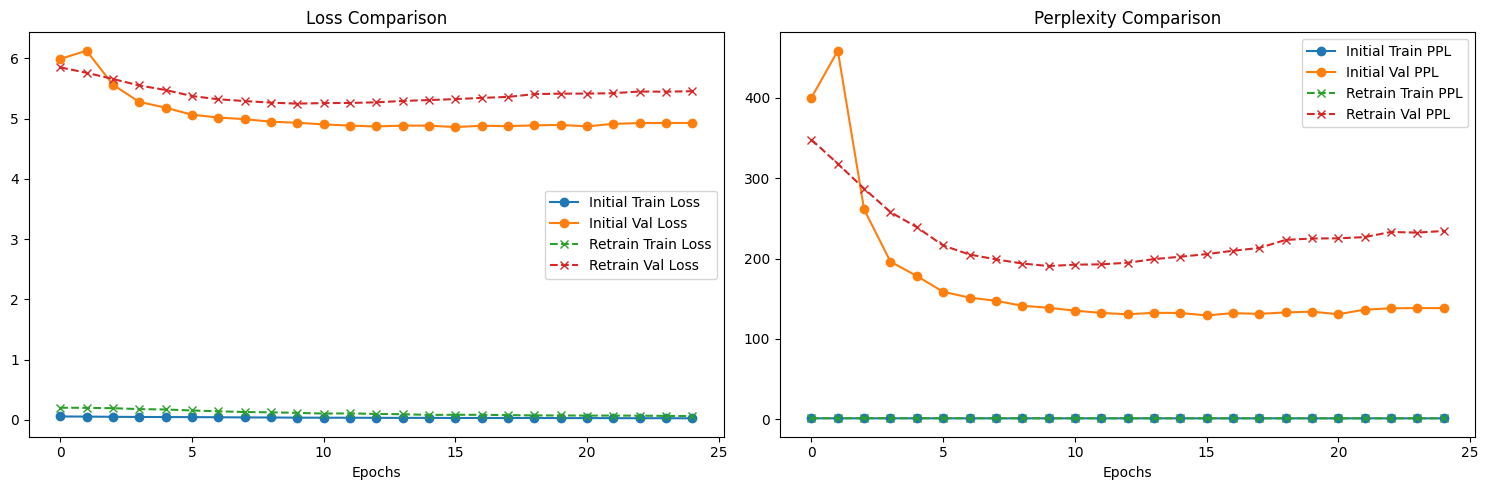

2025-05-02 02:05:33.831 | INFO     | __main__:main:98 - Final Test PPL: 219.13


In [ ]:
#new
# Initialize metric trackers
initial_train_losses = []
initial_valid_losses = []
retrain_train_losses = []
retrain_valid_losses = []
def main():

    # Initial setup
    trial_name = 'influence_baseline'
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps'
                        if torch.backends.mps.is_available() else 'cpu')

    # Load data and build vocabulary
    train_data, valid_data, test_data = load_and_preprocess_data()
    word_to_idx, idx_to_word = build_voab(train_data)

    # Process data and create batches
    train_tensors = process_data(train_data, word_to_idx)
    valid_tensors = process_data(valid_data, word_to_idx)
    test_tensors = process_data(test_data, word_to_idx)

    batch_size = 32
    train_batches = create_batches(train_tensors, word_to_idx, batch_size)
    valid_batches = create_batches(valid_tensors, word_to_idx, batch_size)
    test_batches = create_batches(test_tensors, word_to_idx, batch_size)

    # Initialize model
    model = Network(
        vocab_size=len(word_to_idx),
        embed_size=300,
        hidden_size=512,
        num_layers=1
    ).to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=word_to_idx['<pad>'])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Phase 1: Initial Training
    logger.info("Initial Training Phase")
    train_losses, valid_losses = [], []
    for epoch in range(25):
        train_loss = train(model, train_batches, criterion, optimizer, device)
        valid_loss = evaluate(model, valid_batches, criterion, device)

        logger.info(f"Epoch {epoch+1}/25")
        logger.info(f"Train Loss: {train_loss:.2f} | Valid Loss: {valid_loss:.2f}")
        logger.info(f"Train PPL: {calculate_perplexity(train_loss):.2f} | Valid PPL: {calculate_perplexity(valid_loss):.2f}")
        initial_train_losses.append(train_loss)
        initial_valid_losses.append(valid_loss)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

    # Phase 2: Compute Influences
    logger.info("Computing Influence Values")

    # Ensure gradient computation context
    with torch.autograd.set_detect_anomaly(True):
        valid_grad = get_validation_gradients(model, valid_batches, criterion, device)
        influences = compute_influences(model, train_batches, valid_grad, criterion, device)

    # Phase 3: Select Top 30%
    logger.info("Selecting Top 30% Examples")
    selected_data = select_top_examples(train_data, influences, 0.3)
    selected_tensors = process_data(selected_data, word_to_idx)
    selected_batches = create_batches(selected_tensors, word_to_idx, batch_size)

    # Phase 4: Retrain on Selected Data
    logger.info("Retraining on Selected Examples")
    model = Network(  # Reinitialize model
        vocab_size=len(word_to_idx),
        embed_size=300,
        hidden_size=512,
        num_layers=1
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    retrain_losses = []
    for epoch in range(25):
        train_loss = train(model, selected_batches, criterion, optimizer, device)
        valid_loss = evaluate(model, valid_batches, criterion, device)

        logger.info(f"Retrain Epoch {epoch+1}/25")
        logger.info(f"Train Loss: {train_loss:.2f} | Valid Loss: {valid_loss:.2f}")
        logger.info(f"Train PPL: {calculate_perplexity(train_loss):.2f} | Valid PPL: {calculate_perplexity(valid_loss):.2f}")
        retrain_train_losses.append(train_loss)
        retrain_valid_losses.append(valid_loss)
        retrain_losses.append(train_loss)

    # Final Evaluation
    visualize_results(
    initial_train_losses,
    initial_valid_losses,
    retrain_train_losses,
    retrain_valid_losses
)
    test_loss = evaluate(model, test_batches, criterion, device)
    logger.info(f"Final Test PPL: {calculate_perplexity(test_loss):.2f}")

if __name__ == "__main__":
    main()

In [ ]:

import matplotlib.pyplot as plt

def visualize_results(initial_train, initial_val, retrain_train, retrain_val):
    """Plot training/validation metrics before and after influence selection"""
    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(initial_train, '-o', label='Initial Train Loss')
    plt.plot(initial_val, '-o', label='Initial Val Loss')
    plt.plot(retrain_train, '--x', label='Retrain Train Loss')
    plt.plot(retrain_val, '--x', label='Retrain Val Loss')
    plt.title("Loss Comparison")
    plt.xlabel("Epochs")
    plt.legend()

    # Perplexity plot
    plt.subplot(1, 2, 2)
    plt.plot(torch.exp(torch.tensor(initial_train)), '-o', label='Initial Train PPL')
    plt.plot(torch.exp(torch.tensor(initial_val)), '-o', label='Initial Val PPL')
    plt.plot(torch.exp(torch.tensor(retrain_train)), '--x', label='Retrain Train PPL')
    plt.plot(torch.exp(torch.tensor(retrain_val)), '--x', label='Retrain Val PPL')
    plt.title("Perplexity Comparison")
    plt.xlabel("Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
print(test_loss)

NameError: name 'test_loss' is not defined

In [ ]:
def plot_comparison(initial_train, initial_valid, retrain_train, retrain_valid,
                   labels=('Loss', 'Perplexity'), title_suffix=''):
    """Plot comparison between initial and retraining metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss comparison
    ax1.plot(initial_train, label='Initial Train')
    ax1.plot(initial_valid, label='Initial Valid')
    ax1.plot(retrain_train, label='Retrain Train')
    ax1.plot(retrain_valid, label='Retrain Valid')
    ax1.set_title(f'Loss Comparison {title_suffix}')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(labels[0])
    ax1.legend()

    # Perplexity comparison
    initial_train_ppl = [torch.exp(torch.tensor(x)).item() for x in initial_train]
    initial_valid_ppl = [torch.exp(torch.tensor(x)).item() for x in initial_valid]
    retrain_train_ppl = [torch.exp(torch.tensor(x)).item() for x in retrain_train]
    retrain_valid_ppl = [torch.exp(torch.tensor(x)).item() for x in retrain_valid]

    ax2.plot(initial_train_ppl, label='Initial Train')
    ax2.plot(initial_valid_ppl, label='Initial Valid')
    ax2.plot(retrain_train_ppl, label='Retrain Train')
    ax2.plot(retrain_valid_ppl, label='Retrain Valid')
    ax2.set_title(f'Perplexity Comparison {title_suffix}')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel(labels[1])
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
#new
def main():
    # Initial setup
    trial_name = 'influence_baseline'
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps'
                        if torch.backends.mps.is_available() else 'cpu')

    # Load data and build vocabulary
    train_data, valid_data, test_data = load_and_preprocess_data()
    word_to_idx, idx_to_word = build_voab(train_data)

    # Process data and create batches
    train_tensors = process_data(train_data, word_to_idx)
    valid_tensors = process_data(valid_data, word_to_idx)
    test_tensors = process_data(test_data, word_to_idx)

    batch_size = 32
    train_batches = create_batches(train_tensors, word_to_idx, batch_size)
    valid_batches = create_batches(valid_tensors, word_to_idx, batch_size)
    test_batches = create_batches(test_tensors, word_to_idx, batch_size)

    # Initialize model
    model = Network(
        vocab_size=len(word_to_idx),
        embed_size=300,
        hidden_size=512,
        num_layers=1
    ).to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=word_to_idx['<pad>'])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Phase 1: Initial Training
    logger.info("Initial Training Phase")
    train_losses, valid_losses = [], []
    for epoch in range(25):
        train_loss = train(model, train_batches, criterion, optimizer, device)
        valid_loss = evaluate(model, valid_batches, criterion, device)

        logger.info(f"Epoch {epoch+1}/25")
        logger.info(f"Train Loss: {train_loss:.2f} | Valid Loss: {valid_loss:.2f}")
        logger.info(f"Train PPL: {calculate_perplexity(train_loss):.2f} | Valid PPL: {calculate_perplexity(valid_loss):.2f}")

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

    # Phase 2: Compute Influences
    logger.info("Computing Influence Values")

    # Ensure gradient computation context
    with torch.autograd.set_detect_anomaly(True):
        valid_grad = get_validation_gradients(model, valid_batches, criterion, device)
        influences = compute_influences(model, train_batches, valid_grad, criterion, device)

    # Phase 3: Select Top 30%
    logger.info("Selecting Top 30% Examples")
    selected_data = select_top_examples(train_data, influences, 0.3)
    selected_tensors = process_data(selected_data, word_to_idx)
    selected_batches = create_batches(selected_tensors, word_to_idx, batch_size)

    # Phase 4: Retrain on Selected Data
    logger.info("Retraining on Selected Examples")
    model = Network(  # Reinitialize model
        vocab_size=len(word_to_idx),
        embed_size=300,
        hidden_size=512,
        num_layers=1
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    retrain_losses = []
    for epoch in range(25):
        train_loss = train(model, selected_batches, criterion, optimizer, device)
        valid_loss = evaluate(model, valid_batches, criterion, device)

        logger.info(f"Retrain Epoch {epoch+1}/25")
        logger.info(f"Train Loss: {train_loss:.2f} | Valid Loss: {valid_loss:.2f}")
        logger.info(f"Train PPL: {calculate_perplexity(train_loss):.2f} | Valid PPL: {calculate_perplexity(valid_loss):.2f}")

        retrain_losses.append(train_loss)

    # Final Evaluation
    test_loss = evaluate(model, test_batches, criterion, device)
    logger.info(f"Final Test PPL: {calculate_perplexity(test_loss):.2f}")

if __name__ == "__main__":
    main()